In [2]:
from classy import Class
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%%time
cosmo = Class()
cosmo.set({
    'omega_b': 0.022,
    'omega_cdm': 0.12,
    'h': 0.67,
    'lensing': 'yes',          # enable lensing
    'output': 'tCl,lCl',       # compute temperature + lensing potential spectra
    'l_max_scalars': 2500      # max multipole (optional but useful)
})
cosmo.compute()

print(cosmo.lensed_cl(200)['tt'][0:10])

[0.00000000e+00 0.00000000e+00 1.43149376e-10 6.78328431e-11
 3.85594789e-11 2.46382770e-11 1.70759002e-11 1.25582200e-11
 9.65184501e-12 7.67946043e-12]
CPU times: user 3.32 s, sys: 85.7 ms, total: 3.41 s
Wall time: 565 ms


In [4]:
type(cosmo.lensed_cl(200))

dict

In [5]:
print(cosmo.lensed_cl(200).keys())   # all keys
print(len(cosmo.lensed_cl(200)  )) # all keys
print(len(cosmo.lensed_cl(200)['tt'] )) # all keys
#print(cosmo.lensed_cl(200).values())  # all values
#print(cosmo.lensed_cl(200).items())

dict_keys(['tt', 'pp', 'tp', 'ell'])
4
201


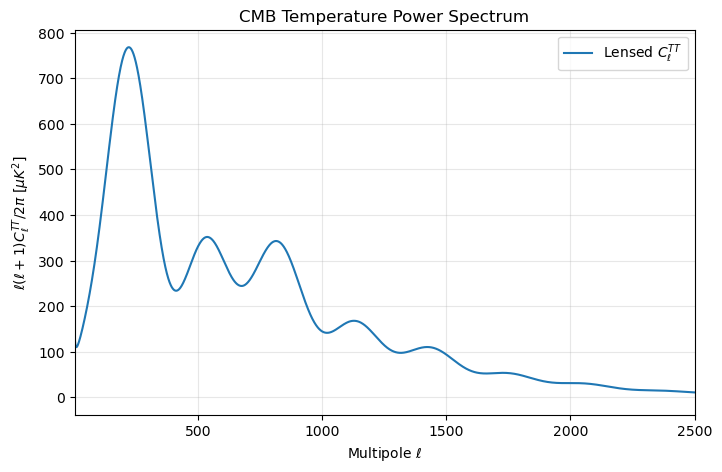

In [6]:
cls = cosmo.lensed_cl()

# Extract arrays
ell = cls['ell']              # multipoles ℓ
cl_tt = cls['tt'] * 1e12      # convert from K^2 to μK^2

# --- 3. Plot ---
plt.figure(figsize=(8,5))
plt.plot(ell, ell*(ell+1)*cl_tt/(2*np.pi), label=r'Lensed $C_\ell^{TT}$')
plt.xlim(2, 2500)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell^{TT}/2\pi \ [\mu K^2]$')
plt.title('CMB Temperature Power Spectrum')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 4. Cleanup ---
cosmo.struct_cleanup()
cosmo.empty()


In [7]:
print(len(cls['tt']))
print(cls.keys())
print(cls['ell'][0:10])


2501
dict_keys(['tt', 'pp', 'tp', 'ell'])
[0 1 2 3 4 5 6 7 8 9]


### Necessary parameters to specify for CLASS:

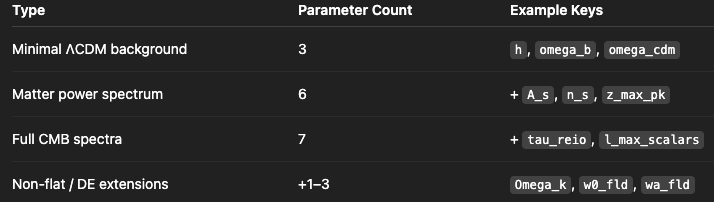

where **_Minimal ΛCDM background_** is minimum ste of parameters for CLASS to compute things like: 
* H(z)
*  a(t)
*  comoving distances
*   age of the Universe

(but not power spectra 𝑃(𝑘) or Cℓ)

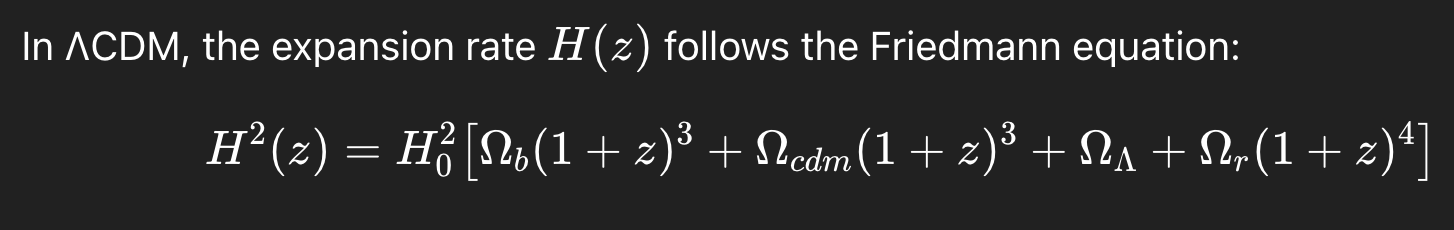

# Dataset ($w_b, \theta_*$)

In [8]:
# save as make_omegab_theta_dataset.py
#import numpy as np
import csv
#from classy import Class

# Planck 2018 reference (will use central values for other params)
omega_b_central = 0.0224        # Planck 2018
omega_cdm_central = 0.120      # Planck 2018
h_central = 0.674              # Planck 2018
A_s = 2.1e-9
n_s = 0.965
tau_reio = 0.054

# domain: omega_b +/- 3 sigma, sigma = 0.0001 (Planck)
sigma_omega_b = 0.0001
omega_b_min = omega_b_central - 3*sigma_omega_b
omega_b_max = omega_b_central + 3*sigma_omega_b

N = 101  # number of samples (grid)
omega_b_values = np.linspace(omega_b_min, omega_b_max, N)

rows = []
for omb in omega_b_values:
    cosmo = Class()
    params = {
        'output': 'tCl',      # we only need derived params like theta_s; this is lightweight
        'h': h_central,
        'omega_b': omb,
        'omega_cdm': omega_cdm_central,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau_reio,
        # optional precision tweaks
        'l_max_scalars': 2000,
    }
    cosmo.set(params)
    cosmo.compute()

    # Get derived parameters. CLASS exposes derived params in a dict.
    derived = cosmo.get_current_derived_parameters(['100*theta_s'])
    # Common keys: '100*theta_s' or 'theta_s'. Use whichever exists.
    if '100*theta_s' in derived:
        theta100 = derived['100*theta_s']
        theta = theta100 / 100.0
        print('1')
    elif 'theta_s' in derived:
        theta = derived['theta_s']
        theta100 = theta * 100.0
        print('2')
    else:
        print('3')
        # fallback: compute from r_s and D_A if needed (rare)
        # but for typical classy builds '100*theta_s' is present
        raise RuntimeError("Derived parameter 100*theta_s not found in CLASS output.")

    rows.append((omb, theta100))

    cosmo.struct_cleanup()   # free internal structures (recommended)
    cosmo.empty()            # free memory

# write CSV
out_csv = "omegab_theta_dataset_planck_3sigma_grid.csv"
with open(out_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['omega_b', '100*theta_s'])
    for r in rows:
        writer.writerow(r)

print(f"Saved {len(rows)} rows to {out_csv}")


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Saved 101 rows to omegab_theta_dataset_planck_3sigma_grid.csv


# NN: $w_b$ -> $\theta_*$

In [8]:
# save as train_theta100_predictor.py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
#import numpy as np

# ======================
# 1. Load dataset
# ======================
data = pd.read_csv("omegab_theta_dataset_planck_3sigma_grid.csv")

# Input (omega_b) and output (100*theta_s)
X = data[['omega_b']].values.astype(np.float32)
y = data[['100*theta_s']].values.astype(np.float32)

# ======================
# 2. Build custom dataset
# ======================
class OmegaThetaDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OmegaThetaDataset(X, y)

# ======================
# 3. Split into train/test
# ======================
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# ======================
# 4. Define Neural Network
# ======================
class Theta100Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = Theta100Predictor()

# ======================
# 5. Training setup
# ======================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ======================
# 6. Training loop
# ======================
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / train_size
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.6e}")

# ======================
# 7. Test loop
# ======================
model.eval()
with torch.no_grad():
    total_loss = 0.0
    for batch_X, batch_y in test_loader:
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        total_loss += loss.item() * batch_X.size(0)

    test_loss = total_loss / test_size
    print(f"\nFinal Test Loss: {test_loss:.6e}")

# ======================
# 8. Example prediction
# ======================
test_input = torch.tensor([[0.0224]], dtype=torch.float32)
pred = model(test_input).item()
print(f"\nPredicted 100*θ_s for ω_b = 0.0224: {pred:.6f}")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/traitlets/config/

RuntimeError: Numpy is not available